# Example: Deep structural causal model counterfactuals

In [1]:
from typing import Dict, List, Optional, Tuple, Union, TypeVar

import torch
import pyro
import pyro.distributions as dist
from pyro.poutine import condition, reparam
from pyro.nn import PyroParam, PyroSample, PyroModule
import pyro.distributions.transforms as Transforms
from pyro.infer import SVI, Trace_ELBO

import causal_pyro
from causal_pyro.query.do_messenger import do
from causal_pyro.counterfactual.handlers import Factual, MultiWorldCounterfactual, TwinWorldCounterfactual

import pandas as pd
import os
import gzip
import struct
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt

/Users/archana/opt/anaconda3/envs/causal_pyro/lib/python3.9/site-packages/tqdm-4.64.1-py3.9.egg/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Background: Normalizing flows and counterfactuals

Much of the causal inference literature has focused on relatively simple
causal models with low dimensional data. In order to perform
counterfactual reasoning in more complex domains with high dimensional
data, Palowski et al. [@pawlowski2020deep] introduced *deep structural
causal models* (Deep SCMs): SCMs with neural networks as the functional
mechanisms between variables.

Specifically, the neural networks are
*normalizing flows*. A normalizing flow transforms a base probability
distribution (often a simple distribution, such as a multivariate
Gaussian) through a sequence of invertible transformations into a more
complex distribution (such as a distribution over images). When used
within a Deep SCM, the flow's base distribution is an exogenous noise
variable, and its output is an endogenous variable.

A salient property
of normalizing flows is that computing the likelihood of data can be
done both exactly and efficiently, and hence training a flow to model a
data distribution through maximum likelihood is straightforward. In
addition, the inverse of a normalizing flow can also typically be
efficiently computed, which renders the abduction step of a
counterfactual---inferring the posterior over exogenous variables given
evidence---trivial.

## Example: Morpho-MNIST

We consider a synthetic dataset based on MNIST, where the image of each digit ($X$) depends on stroke thickness ($T$) and brightness ($I$) of the image and the thickness depends on brightness as well.

We assume we know full causal structure (i.e., there are no unconfounded variables).

In [2]:
def load_idx(path: str) -> np.ndarray:
    """Reads an array in IDX format from disk.
    Parameters
    ----------
    path : str
        Path of the input file. Will uncompress with `gzip` if path ends in '.gz'.
    Returns
    -------
    np.ndarray
        Output array of dtype ``uint8``.
    References
    ----------
    http://yann.lecun.com/exdb/mnist/
    """
    open_fcn = gzip.open if path.endswith('.gz') else open
    with open_fcn(path, 'rb') as f:
        idx_dtype, ndim = struct.unpack('BBBB', f.read(4))[2:]
        shape = struct.unpack('>' + 'I' * ndim, f.read(4 * ndim))
        buffer_length = int(np.prod(shape))
        data = np.frombuffer(f.read(buffer_length), dtype=np.uint8).reshape(shape).astype(np.float32)
        return data
    
path = os.path.join(os.getcwd(), "../datasets/morphomnist/")
metrics = pd.read_csv(path + "train-morpho.csv", index_col= 'index')
# raw_labels = load_idx(path+"train-labels-idx1-ubyte.gz")
raw_images = load_idx(path+"train-images-idx3-ubyte.gz")

thickness = torch.tensor(metrics["thickness"], dtype=torch.float32)
intensity = torch.tensor(metrics["intensity"], dtype=torch.float32)
# labels = torch.tensor(raw_labels, dtype=torch.float32)
images = torch.tensor(raw_images, dtype=torch.float32)

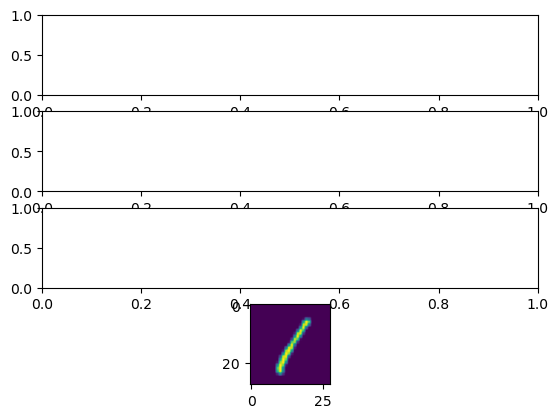

In [3]:
f, ax = plt.subplots(4, 1)
ax[0] = plt.imshow(images[0])
ax[1] = plt.imshow(images[1])
ax[2] = plt.imshow(images[2])
ax[3] = plt.imshow(images[3])
plt.show()

## Model: deep structural causal model

The following code models morphological transformations of MNIST,
defining a causal generative model over digits that contains endogenous
variables to control the width $t$ and intensity $i$ of the stroke:

In [ ]:
params = {"intensity_flow_bias": intensity.min(),
"intensity_flow_weight": (intensity.max() - intensity.min()),
"thickness_flow_bias": thickness.log().mean(),
"thickness_flow_weight": thickness.log().std()}

In [ ]:
# class DeepSCM_old(PyroModule):
#     def __init__(self,
#                  SetThickness = Transforms.conditional_spline(input_dim=28*28, context_dim=1, count_bins=16),
#                  SetIntensity = Transforms.conditional_spline(input_dim=28*28, context_dim=1, count_bins=16)
#                 ):
#         super().__init__()
#         self.SetThickness = SetThickness
#         self.SetIntensity = SetIntensity
    
#     def forward(self):
#         UT = dist.Gamma(10, 5).expand([1]).to_event(1)
#         UI = dist.Normal(0, 1).expand([1]).to_event(1)
#         UX = dist.Normal(0, 1).expand([28*28]).to_event(1)
#         T = pyro.sample("T", dist.TransformedDistribution(UT, [Transforms.AffineTransform(0.5, 1)]))
#         I_transforms = [
#             Transforms.AffineTransform(2*T - 5, 0.5),
#             Transforms.SigmoidTransform(),
#             Transforms.AffineTransform(64, 191)
#         ]
#         I = pyro.sample("I", dist.TransformedDistribution(UI, I_transforms))
#         flow_dist_thickness = dist.ConditionalTransformedDistribution(UX, [self.SetThickness])
#         flow_dist_thickness = flow_dist_thickness.condition(context=T)
#         flow_dist_intensity = dist.ConditionalTransformedDistribution(flow_dist_thickness, [self.SetIntensity])
#         flow_dist_intensity = flow_dist_intensity.condition(context=I)
#         X = pyro.sample("X", flow_dist_intensity)
#         return X

# scm_old = DeepSCM_old()
# print(list(dict(scm_old.named_parameters()).keys()))
# pyro.render_model(scm_old, model_args=())

In [ ]:
class DeepSCM(PyroModule):
    def __init__(self):
        super().__init__()
        # Thickness parameters
        self.thickness_param = Transforms.Spline(1)
        
        # Intensity parameters
        intensity_net = pyro.nn.ConditionalAutoRegressiveNN(1, 1, hidden_dims=[10], nonlinearity=torch.nn.Identity())
        self.intensity_param = Transforms.ConditionalAffineAutoregressive(intensity_net)
        
        # Image parameters
        self.f_X = Transforms.conditional_affine_autoregressive(input_dim=28*28, context_dim=2)
        self.img_affine_coupling = Transforms.affine_coupling(input_dim=28*28)
#         self.img_batchnorm = Transforms.batchnorm(input_dim=28*28)   # Takes too long -- breaks render_model
        self.img_planar = Transforms.affine_autoregressive(input_dim=28*28)
        
    def forward(self):
        UT = dist.Gamma(10, 5).expand([1]).to_event(1)
        UI = dist.Normal(0, 1).expand([1]).to_event(1)
        UX = dist.Normal(0, 1).expand([28*28]).to_event(1)
        T = pyro.sample("T", dist.TransformedDistribution(UT, [Transforms.AffineTransform(0.5, 1)]))
        I_transforms = [
            Transforms.AffineTransform(2*T - 5, 0.5),
            Transforms.SigmoidTransform(),
            Transforms.AffineTransform(64, 191)
        ]
        I = pyro.sample("I", dist.TransformedDistribution(UI, I_transforms))
        
#         # Thickness:
#         UT = dist.Normal(0, 1).expand([1]).to_event(1)
#         thickness_flow_loc = params["thickness_flow_bias"]
#         thickness_flow_scale = params["thickness_flow_weight"]
#         thickness_flow_lognorm = Transforms.AffineTransform(loc=thickness_flow_loc, scale=thickness_flow_scale)
#         t_transforms = [
#             self.thickness_param,
#             thickness_flow_lognorm,
#             Transforms.ExpTransform()
#         ]
#         T = pyro.sample("T", dist.TransformedDistribution(UT, t_transforms))
        
        
#         # Intensity:
#         UI = dist.Normal(0, 1).expand([1]).to_event(1)
#         intensity_flow_loc = params["intensity_flow_bias"]
#         intensity_flow_scale = params["intensity_flow_weight"]
#         intensity_flow_norm = Transforms.AffineTransform(loc=intensity_flow_loc, scale=intensity_flow_scale)
#         intensity_tranforms = [
#             self.intensity_param,
#             Transforms.SigmoidTransform(), 
#             intensity_flow_norm
#         ]
#         I = pyro.sample("I", dist.ConditionalTransformedDistribution(UI, intensity_tranforms).condition(context=T))
        
        
        # Image:
        UX = dist.Normal(0, 1).expand([28*28]).to_event(1)
        
        # Preprocessing
        alpha = 0.005
        num_bits = 8
        s = Transforms.SigmoidTransform()
        preprocess_transform = Transforms.ComposeTransform([
            Transforms.AffineTransform(0., (1. / 2 ** num_bits)),
            Transforms.AffineTransform(alpha, (1 - alpha)),
            s.inv
        ])
        
        # NF Layers for image:
        img_affine_coupling = self.img_affine_coupling
#         img_batchnorm = self.img_batchnorm
        img_planar = self.img_planar
        
        
        h_X = dist.ConditionalTransformedDistribution(UX, [preprocess_transform,
                                                           self.f_X, 
                                                           img_affine_coupling,
#                                                          img_batchnorm,
                                                           img_planar])
        h_X = h_X.condition(context=torch.cat((T, I), dim=-1))
        assert torch.cat((T, I), dim=-1).shape[-1:] == (2,)
        X = pyro.sample("X", h_X)
        return X

In [ ]:
scm = DeepSCM()
print(list(dict(scm.named_parameters()).keys()))
print(pyro.poutine.trace(scm).get_trace().log_prob_sum())
pyro.render_model(scm)

In [ ]:
intervened_scm = do(scm, {"T": torch.randn(1)})
# intervened_scm()
pyro.render_model(intervened_scm)

In [ ]:
def conditioned_scm(model):
    def query_model(t_obs, i_obs, x_obs):
        with pyro.condition(data={"X": x_obs, "T": t_obs, "I": i_obs}), \
                pyro.plate("data", size=x_obs.shape[0], dim=-1):
            return model()
    return query_model

conditioned_model = conditioned_scm(scm)
imgs = conditioned_model(thickness[:3, None], intensity[:3, None], images[:3].reshape(-1, 28*28))
pyro.render_model(conditioned_model, model_args=(thickness[:2][..., None], intensity[:2][..., None], images[:2].reshape(-1, 28*28)))

In [ ]:
plt.imshow(imgs[0].reshape((28, 28)))

In [ ]:
adam_params = {"lr": 0.0001, "betas": (0.90, 0.999)}
optimizer = pyro.optim.ClippedAdam(adam_params)
empty_guide = lambda *args: None
svi = SVI(conditioned_model, empty_guide, optimizer, loss=Trace_ELBO(num_particles=4, vectorize_particles=True))
predictive = pyro.infer.Predictive(scm, guide=empty_guide, num_samples=32)

pyro.clear_param_store()
n_steps = 1000
for i in range(5):
    batch_idx = torch.randperm(images.shape[0])[:256]
    loss = svi.step(thickness[batch_idx, None], intensity[batch_idx, None], images[batch_idx].reshape(-1, 28*28))
    print(loss)

In [ ]:
img = predictive()["X"]

In [ ]:
plt.imshow(img.detach().reshape((28, 28)))

## Query: counterfactual data generation

Next we ask a *counterfactual* question: given an observed digit $X$, what
would the digit have been had $t$ been $t + 1$?

To compute this quantity we would normally:
   1. invert the model to find latent exogenous noise $u$
   2. construct an intervened model
   3. re-simulate the forward model on the $u$ [@pearl2011algorithmization].  

However, we can equivalently
represent this process with inference in a single, expanded
probabilistic program containing two copies of every deterministic
statement (a so-called \"twin network\" representation of
counterfactuals, first described in Chapter 7 of [@pearl] and extended
to the PPL setting in [@tavares_2020])

In [ ]:
x_obs = torch.tensor(np.array(Image.open(path+"images_5/0")).flatten())
plt.imshow(x_obs.detach().reshape((28, 28)))

In [ ]:
def deep_scm_query(model: DeepSCM):
    return do(actions={"T": 1})(
        condition(data={"X": x_obs})(
            TwinWorldCounterfactual(dim=-1)(
                reparam(config=pyro.infer.reparam.AutoReparam())(
                    model))))

cf_model = deep_scm_query(p)

In [ ]:
plt.imshow(cf_model().detach().reshape((28, 28)))

Like all counterfactuals, this estimand is not identified in general
without further assumptions: learning parameters $\theta$ that match
observed data does not guarantee that the counterfactual distribution
will match that of the true causal model. 

However, as discussed in the
original paper [@pawlowski2020deep] in the context of modeling MRI
images, there are a number of valid practical reasons one might wish to
compute it anyway, such as explanation or expert evaluation.